### Open File

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('./data/df_features.gz')

I delete the rows without a distance to city center (because in the origin hotel don't have latitude and longitude)

In [3]:
df = df.dropna(subset=['Dist_Center'])
# df = df.dropna(subset=['Reservation_ADR'])

### Create Predicted Category for final models (2 categories)

In [4]:
diff_hotels = df[['Hotel_Address','Diff_Percentage']].groupby('Hotel_Address').describe()
diff_hotels = diff_hotels.Diff_Percentage.reset_index()

In [5]:
df = pd.merge(df, diff_hotels, on='Hotel_Address')

In [6]:
category = np.array(['Bad' if i < 0.7 else 'Good' for i in df.Diff_Percentage])
df.loc[:, 'Category'] = category
df.Category.value_counts() / len(df) 

Good    0.917609
Bad     0.082391
Name: Category, dtype: float64

In [7]:
df.columns

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score',
       'days_since_review', 'lat', 'lng', 'Diff', 'Diff_Percentage',
       'Review_Month', 'Review_Year', 'Country', 'City', 'Pet', 'Purpose',
       'Whom', 'Room', 'Length', 'Device', 'Room_Recode', 'Nationality_Recode',
       'Length_Recode', 'Close_Landmarks', 'Dist_Center', 'Dist_Airport',
       'Dist_Train', 'Price', 'Stars', 'Length_N', 'Reservation_ADR',
       'food_Neg', 'staff_Neg', 'location_Neg', 'value_Neg', 'comfort_Neg',
       'room_Neg', 'facilities_Neg', 'cleanliness_Neg', 'food_Pos',
       'staff_Pos', 'location_Pos', 'value_Pos', 'comfort_Pos', 'room_Pos',
       'facilities_Pos', 'cleanliness_Pos', 'food_Neg_Hotel',
       'staff_Neg_Hotel', 'loca

### Balance Nationalities and / or Categories

In [8]:
def balance_df(Balance_Nationality, Balance_Category):
    df_balance_country = df.copy()
    if Balance_Nationality:
        df_balance_country = None
        for i in list(df.Nationality_Recode.value_counts().index):
            nationality = df[df.Nationality_Recode == i]
            n = 20000
            if len(nationality) < 20000:
                n = len(nationality)
            nationality = nationality.sample(n, random_state=1)
            df_balance_country = pd.concat([df_balance_country, nationality])
    
    df_balance_class = df_balance_country.copy()
    if Balance_Category:
        df_balance_class = None
        minclass = np.min(df_balance_country.Category.value_counts())
        classes = list(df_balance_country.Category.value_counts().index)
        for i in classes:
            selected_class = df_balance_country[df_balance_country.Category == i].sample(minclass, random_state=1)
            df_balance_class = pd.concat([df_balance_class, selected_class])
    
    return(df_balance_class)

In [9]:
df_balanced = balance_df(Balance_Nationality=True, Balance_Category=True)

### Prepare Data to run Models

In [10]:
df_model = df_balanced.sample(n=20000, random_state=1)

In [11]:
x_categorical = ['Review_Month','City','Pet','Purpose','Whom','Room_Recode','Nationality_Recode','Length_Recode','Stars']
x_numerical = ['Average_Score', 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Close_Landmarks', 'Dist_Center', 
               'Dist_Train', 'Dist_Airport','food_Neg_Hotel','staff_Neg_Hotel', 'location_Neg_Hotel', 'value_Neg_Hotel',
               'comfort_Neg_Hotel', 'room_Neg_Hotel', 'facilities_Neg_Hotel','cleanliness_Neg_Hotel', 
               'food_Pos_Hotel', 'staff_Pos_Hotel','location_Pos_Hotel', 'value_Pos_Hotel', 'comfort_Pos_Hotel',
               'room_Pos_Hotel', 'facilities_Pos_Hotel', 'cleanliness_Pos_Hotel','count', 'mean', 'std', 'min', '25%', 
               '50%', '75%', 'max']
x_col = x_categorical + x_numerical
y_col = 'Category'

In [12]:
X_numerical = df_model[x_numerical]
X_numerical_std = X_numerical.apply(lambda x: ((x-np.mean(x)) / np.std(x)))

In [13]:
X_categorical = pd.get_dummies(df_model[x_categorical], prefix_sep='_', drop_first=True)
X_categorical = X_categorical.fillna('Not Available')

In [14]:
X = pd.concat([X_numerical_std, X_categorical], axis=1, sort=False)
y = df_model[y_col]

Split into Train and Test

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=100)

In [16]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((10000, 67), (10000,), (10000, 67), (10000,))

## MODELS

### Evaluate Model

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB

from sklearn.metrics import classification_report, accuracy_score, cohen_kappa_score, f1_score, precision_score, recall_score

In [18]:
def evaluate(model):
    clf = model
    clf.fit(X_train, y_train)
    train = clf.predict(X_train)
    pred = clf.predict(X_test)
    print('Test :', f'{accuracy_score(pred, y_test):.4f}', '|', f'{cohen_kappa_score(pred, y_test):.4f}')
    print('Train:', f'{accuracy_score(train, y_train):.4f}', '|', f'{cohen_kappa_score(train, y_train):.4f}')
    return(pred)

### KNN

In [19]:
pred_knn = evaluate(KNeighborsClassifier(n_neighbors=5))

Test : 0.5750 | 0.1501
Train: 0.7141 | 0.4281


### Gradient Boosted Trees

In [20]:
pred_gbt = evaluate(GradientBoostingClassifier(learning_rate=0.04, max_depth=3, random_state=1))

Test : 0.6332 | 0.2675
Train: 0.6494 | 0.2981


### Random Forest

In [21]:
pred_rf = evaluate(RandomForestClassifier(n_estimators = 200, max_depth = 5, random_state=1))

Test : 0.6171 | 0.2363
Train: 0.6298 | 0.2583


### XGBoosting

In [22]:
pred_xgb = evaluate(xgb.XGBClassifier(objective="binary:logistic", n_estimators = 20, max_depth=3, random_state=1))

Test : 0.6318 | 0.2646
Train: 0.6521 | 0.3036


### Logistic Regresion

In [23]:
pred_log = evaluate(LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1))

Test : 0.6370 | 0.2744
Train: 0.6324 | 0.2644


### Decision Trees

In [24]:
pred_tree = evaluate(DecisionTreeClassifier(max_depth=5, random_state=1))

Test : 0.6139 | 0.2256
Train: 0.6249 | 0.2511


### SVM

In [25]:
pred_svm = evaluate(SVC(C=0.5, random_state=1))

Test : 0.6281 | 0.2574
Train: 0.6443 | 0.2878


### Naive Bayes

In [26]:
pred_nb = evaluate(BernoulliNB())

Test : 0.6062 | 0.2122
Train: 0.6039 | 0.2078


### Models Summary

In [27]:
df_models_test = pd.DataFrame(list(zip(y_test, pred_log, pred_knn, pred_xgb, pred_gbt, pred_rf, 
                                       pred_svm, pred_tree, pred_nb)), 
                         columns=['TEST','logistic','knn','xgb','gbt','rf','svm', 'tree', 'nb']) 
df_models_test.head()

,TEST,logistic,knn,xgb,gbt,rf,svm,tree,nb
0,Good,Bad,Bad,Good,Good,Bad,Bad,Good,Bad
1,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad
2,Good,Good,Good,Good,Good,Good,Good,Good,Good
3,Bad,Good,Good,Good,Good,Bad,Good,Good,Bad
4,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad


## STACKING

Predictions using Random Forest adding the predicions of other models to the original dataset.
I had to split the test set in 2 to create the new train/test set, otherwise i fall into overfitting because my original training set is biased vs the test set

First I append the predictions of the model to the dataset

In [28]:
X_2 = X_test.copy()
y_2 = y_test.copy()

In [29]:
X_2['logistic'] = pred_log
X_2['gbt'] = pred_gbt
X_2['knn'] = pred_knn
X_2['svm'] = pred_svm
X_2['tree'] = pred_tree
X_2['xgb'] = pred_xgb
X_2['nb'] = pred_nb
X_2['rf'] = pred_rf

In [30]:
X_2.iloc[:,-8:].head(2)

,logistic,gbt,knn,svm,tree,xgb,nb,rf
465506,Bad,Good,Bad,Bad,Good,Good,Bad,Bad
102127,Bad,Bad,Bad,Bad,Bad,Bad,Bad,Bad


In [31]:
X_2.iloc[:,-8:] = X_2.iloc[:,-8:].apply(lambda x: [1 if i=='Good' else 0 for i in x])

In [32]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=100)

### Stacked Model

In [33]:
models = [('Random Forest', RandomForestClassifier(n_estimators = 200, max_depth = 5, random_state=1)), 
          ('XGB', xgb.XGBClassifier(objective="binary:logistic", n_estimators = 20, max_depth=3, random_state=1)),
          ('GBT', GradientBoostingClassifier(learning_rate=0.005, max_depth=3, random_state=1)),
          ('Logistic', LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)),
          ('SVM', SVC(C=0.5, random_state=1))
         ]

for i in models:
    clf = i[1]
    clf.fit(X_train_2, y_train_2)
    train_stck_2 = clf.predict(X_train_2)
    pred_stck_2 = clf.predict(X_test_2)
    print(i[0])
    print('Test :',f'{accuracy_score(pred_stck_2, y_test_2):.4f}', '|',f'{cohen_kappa_score(pred_stck_2, y_test_2):.4f}')
    print('Train:',f'{accuracy_score(train_stck_2, y_train_2):.4f}', '|',f'{cohen_kappa_score(train_stck_2, y_train_2):.4f}')
    print('----------------------')

Random Forest
Test : 0.6350 | 0.2717
Train: 0.6505 | 0.3015
----------------------
XGB
Test : 0.6360 | 0.2724
Train: 0.6591 | 0.3185
----------------------
GBT
Test : 0.6385 | 0.2773
Train: 0.6406 | 0.2815
----------------------
Logistic
Test : 0.6415 | 0.2829
Train: 0.6454 | 0.2909
----------------------
SVM
Test : 0.6375 | 0.2768
Train: 0.6462 | 0.2931
----------------------


#### Backward Elimination

In [34]:
import random
from random import sample

In [35]:
def check_model(variable, X_train, X_test, y_train, y_test):
    clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)   
    # clf = GradientBoostingClassifier(learning_rate=0.005, max_depth=3, random_state=1)
    clf.fit(X_train, y_train)
    prediccion = clf.predict(X_test)
    acc_score = accuracy_score(prediccion, y_test)
    return(variable, acc_score)

In [36]:
def try_seed(seed, verbose=False):
    score = check_model('', X_train_2, X_test_2, y_train_2, y_test_2)[1]
    varout = []
    varin = list(X_test_2.columns)

    for n in range(len(varin)):
        max_score = score
        max_feature = []
        random.seed(seed)
        
        for i in sample(varin, len(varin)):
            var_test = varin.copy()
            var_test.remove(i)
            X_train_vartest = X_train_2[var_test]
            X_test_vartest = X_test_2[var_test]
            check = check_model(i, X_train_vartest, X_test_vartest, y_train_2, y_test_2)
            if check[1] > max_score:
                max_feature = check[0]
                max_score = check[1] 
                varin.remove(max_feature)   
                varout.append(max_feature)
                if verbose:
                    print('{0:0=2d}'.format(n), 'Original Score:', f'{score:.4f}', '| New score:', f'{max_score:.4f}', 
                          '| Variable to remove:', max_feature)
                break

        if max_score > score:
            score = max_score
        else:
            print('Seed:',seed, '<-', score)
            return(varin)
            break

In [37]:
for seed in range(5):
    try_seed(seed)

Seed: 0 <- 0.646
Seed: 1 <- 0.647
Seed: 2 <- 0.6455
Seed: 3 <- 0.6425
Seed: 4 <- 0.652


In [38]:
varin = try_seed(4, True)

00 Original Score: 0.6415 | New score: 0.6420 | Variable to remove: food_Neg_Hotel
01 Original Score: 0.6420 | New score: 0.6425 | Variable to remove: food_Pos_Hotel
02 Original Score: 0.6425 | New score: 0.6430 | Variable to remove: Whom_Solo traveler
03 Original Score: 0.6430 | New score: 0.6440 | Variable to remove: value_Neg_Hotel
04 Original Score: 0.6440 | New score: 0.6445 | Variable to remove: Nationality_Recode_UK & Ireland
05 Original Score: 0.6445 | New score: 0.6460 | Variable to remove: location_Pos_Hotel
06 Original Score: 0.6460 | New score: 0.6470 | Variable to remove: Room_Recode_Other (Standard)
07 Original Score: 0.6470 | New score: 0.6475 | Variable to remove: Room_Recode_Studio
08 Original Score: 0.6475 | New score: 0.6480 | Variable to remove: Dist_Center
09 Original Score: 0.6480 | New score: 0.6485 | Variable to remove: Dist_Train
10 Original Score: 0.6485 | New score: 0.6490 | Variable to remove: Length_Recode_Stayed 8 nights
11 Original Score: 0.6490 | New sco

In [39]:
X_train_varin = X_train_2[varin]
X_test_varin = X_test_2[varin]
clf = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=1)    
clf.fit(X_train_varin, y_train_2)
prediction = clf.predict(X_test_varin)
probability = clf.predict_proba(X_test_varin)

(array([  9.,  23.,  36.,  76., 105., 132., 149., 170., 182., 168., 157.,
        141., 135., 136., 119.,  91.,  79.,  62.,  23.,   7.]),
 array([0.0912537 , 0.13333018, 0.17540666, 0.21748315, 0.25955963,
        0.30163611, 0.34371259, 0.38578907, 0.42786556, 0.46994204,
        0.51201852, 0.554095  , 0.59617148, 0.63824797, 0.68032445,
        0.72240093, 0.76447741, 0.8065539 , 0.84863038, 0.89070686,
        0.93278334]),
 <a list of 20 Patch objects>)

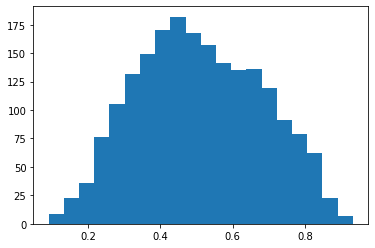

In [40]:
plt.hist(probability[:,1], bins=20)

In [41]:
pd.crosstab(prediction, y_test_2)

Category,Bad,Good
row_0,,
Bad,633,362
Good,334,671


In [42]:
print(f'{accuracy_score(prediction, y_test_2):.4f}', '<- Accuracy')
print(f'{cohen_kappa_score(prediction, y_test_2):.4f}', '<- Kappa')
print(f'{f1_score(prediction, y_test_2, pos_label="Bad"):.4f}', '<- F1')

0.6520 <- Accuracy
0.3039 <- Kappa
0.6453 <- F1


#### F1 analysis

In [43]:
prob_bad = probability[:,0]
for thr in np.arange(0.4, 0.6, 0.01):
    classification = ['Bad' if i > thr else 'Good' for i in prob_bad]
    accuracy = accuracy_score(classification, y_test_2)
    kappa = cohen_kappa_score(classification, y_test_2)
    f1 = f1_score(classification, y_test_2, pos_label='Bad')
    avg =np.mean([accuracy, f1])
    print('Threshold:', f'{thr:.2f}', '| Accuracy:', f'{accuracy:.4f}', '| Kappa:', f'{kappa:.4f}', '| F1:', f'{f1:.4f}', 
          '| Avg:', f'{avg:.4f}')

Threshold: 0.40 | Accuracy: 0.6140 | Kappa: 0.2372 | F1: 0.6690 | Avg: 0.6415
Threshold: 0.41 | Accuracy: 0.6185 | Kappa: 0.2453 | F1: 0.6684 | Avg: 0.6435
Threshold: 0.42 | Accuracy: 0.6215 | Kappa: 0.2505 | F1: 0.6667 | Avg: 0.6441
Threshold: 0.43 | Accuracy: 0.6240 | Kappa: 0.2547 | F1: 0.6640 | Avg: 0.6440
Threshold: 0.44 | Accuracy: 0.6230 | Kappa: 0.2517 | F1: 0.6566 | Avg: 0.6398
Threshold: 0.45 | Accuracy: 0.6250 | Kappa: 0.2547 | F1: 0.6528 | Avg: 0.6389
Threshold: 0.46 | Accuracy: 0.6265 | Kappa: 0.2568 | F1: 0.6478 | Avg: 0.6372
Threshold: 0.47 | Accuracy: 0.6355 | Kappa: 0.2738 | F1: 0.6500 | Avg: 0.6428
Threshold: 0.48 | Accuracy: 0.6315 | Kappa: 0.2650 | F1: 0.6403 | Avg: 0.6359
Threshold: 0.49 | Accuracy: 0.6395 | Kappa: 0.2799 | F1: 0.6400 | Avg: 0.6398
Threshold: 0.50 | Accuracy: 0.6520 | Kappa: 0.3039 | F1: 0.6453 | Avg: 0.6486
Threshold: 0.51 | Accuracy: 0.6425 | Kappa: 0.2840 | F1: 0.6286 | Avg: 0.6355
Threshold: 0.52 | Accuracy: 0.6400 | Kappa: 0.2781 | F1: 0.6182 